In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


df = pd.read_csv('csv_46.635417_32.616867_fixed_23_180_PT60M/csv_46.635417_32.616867_fixed_23_180_PT60M.csv')
# Convert the 'value' column to a numpy array
data = df['gti'].values

In [2]:
# Normalize the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

# Create sequences of data for input and target
sequence_length = 24  # Length of the input sequence (past 24 hours)
target_length = 24*30   # Length of the target sequence (next month)

X, y = [], []
for i in range(len(data) - sequence_length - target_length + 1):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length:i+sequence_length+target_length])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

# Build the LSTM model
model = Sequential()
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(target_length))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, callbacks=[early_stopping], epochs=100, batch_size=32)
model.save('lstm_1week_month_all.h5')



Epoch 1/100
1697/1697 [==============================] - 10s 5ms/step - loss: 0.0241
Epoch 2/100
1697/1697 [==============================] - 9s 5ms/step - loss: 0.0176
Epoch 3/100
1697/1697 [==============================] - 9s 5ms/step - loss: 0.0169
Epoch 4/100
1697/1697 [==============================] - 9s 6ms/step - loss: 0.0167
Epoch 5/100
1697/1697 [==============================] - 9s 5ms/step - loss: 0.0165
Epoch 6/100
1697/1697 [==============================] - 9s 6ms/step - loss: 0.0164
Epoch 7/100
1697/1697 [==============================] - 9s 5ms/step - loss: 0.0163
Epoch 8/100
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0162
Epoch 9/100
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0162
Epoch 10/100
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0161
Epoch 11/100
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0161
Epoch 12/100
1697/1697 [==============================] - 8s 5ms/step - l

C:\projects\cassini\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
from keras.models import load_model

model = load_model('lstm_1week_month_all.h5')
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

425/425 [==============================] - 1s 2ms/step - loss: 0.0153
Test loss: 0.015286248177289963


In [5]:
prediction = model.predict(X_test)
print(prediction)

425/425 [==============================] - 1s 2ms/step
[[-0.00870371 -0.00833854  0.04140151 ...  0.00300904  0.01340525
   0.0120746 ]
 [ 0.45043287  0.60796773  0.70891714 ... -0.0038128   0.04462925
   0.1444111 ]
 [ 0.00081857  0.00769198  0.0144971  ...  0.02528     0.01188191
   0.00743836]
 ...
 [ 0.07650053 -0.01035438 -0.04321137 ...  0.5274342   0.42904592
   0.30352232]
 [-0.01243558 -0.01303232 -0.01652491 ...  0.2635873   0.13318935
   0.04824425]
 [ 0.10993741  0.21124357  0.29639795 ... -0.01068118 -0.01122017
   0.01383806]]


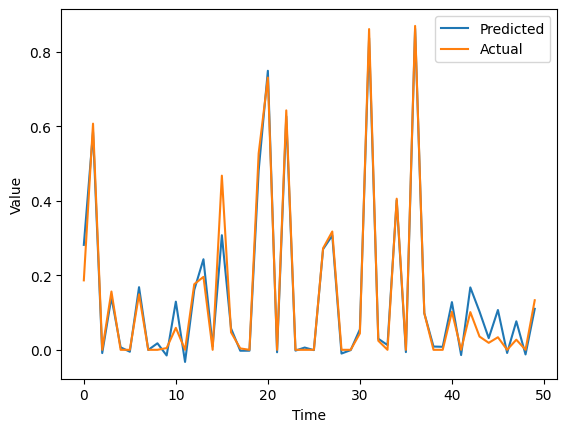

In [6]:
size = 50
plt.plot(range(size), prediction[-size:,0], label='Predicted')
plt.plot(range(size), y_test[-size:,0], label='Actual')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig('lstm_1week_month_all.png')
plt.show()